In [1]:
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.exceptions import ConvergenceWarning
from tqdm import tqdm, tqdm_notebook

# Preprocessing

### Import Dataset

In [2]:
df = pd.read_csv(
    "../Datasets/Raw_Data/GSE221521_gene_expression.csv", index_col=1)
df.head()

,gene_id,description,gene_type,locus,RNA1_FPKM,RNA102_FPKM,RNA104_FPKM,RNA108_FPKM,RNA109_FPKM,RNA110_FPKM,...,R_JS032_count,R_JS033_count,R_JS034_count,R_JS035_count,R_JS036_count,R_JS037_count,R_JS038_count,R_JS039_count,R_JS040_count,R_JS041_count
gene_name,,,,,,,,,,,,,,,,,,,,,
AC073488.4,ENSG00000282222,"chromodomain protein, Y chromosome-like (CDYL)...",processed_pseudogene,X:9410789-9411545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
AC119427.1,ENSG00000282221,"novel transcript, antisense to LAD1",lncRNA,1:201399633-201401190,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
MIR543,ENSG00000212040,microRNA 543 [Source:HGNC Symbol;Acc:HGNC:33664],miRNA,14:101031987-101032064,0.000000,0.000000,0.000000,0.000000,0.000000,0.962816,...,0,0,0,0,0,0,0,0,0,0
MADD,ENSG00000110514,MAP kinase activating death domain [Source:HGN...,protein_coding,11:47269161-47330031,6.345943,8.482109,10.209322,7.143557,5.671481,7.776351,...,1187,1254,1767,1184,2418,1294,1254,1461,1323,1795
AL356737.2,ENSG00000287159,"novel transcript, antisense to GPC5",lncRNA,13:92610646-92677725,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


### Check Gene Types

In [3]:
df['gene_type'].value_counts()

protein_coding                        19973
lncRNA                                16889
processed_pseudogene                  10162
unprocessed_pseudogene                 2612
misc_RNA                               2220
snRNA                                  1910
miRNA                                  1879
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      938
transcribed_processed_pseudogene        500
rRNA_pseudogene                         496
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
rRNA                                     53
scaRNA                                   49
polymorphic_pseudogene                   48
IG_D_gene                                37
TR_V_pseudogene                 

### Transform the Dataset

In [4]:
df = df[df['gene_type'] == 'snRNA']
df = df.drop(['gene_type', 'description', 'gene_id', 'locus'], axis=1)
df = df.iloc[:, :193]
df = df.T
df.to_csv('../Datasets/Dataset10/data0.csv')

### Combine with Diagnosis

In [5]:
df = pd.read_csv('../Datasets/Dataset10/data0.csv', index_col=0)
diagnosis = pd.read_csv("../Datasets/Dataset05/Diagnosis.csv", index_col=0)
df['Diagnosis'] = diagnosis['Diagnosis']
df.to_csv('../Datasets/Dataset10/data1.csv')

df.head()

,RNU7-186P,RNU1-82P,U6,RNU6-749P,RNU6-1208P,RNU6-377P,RNU6-1129P,RNU4-54P,RNU6-209P,RNU6-566P,...,RNU1-33P,RNU4-43P,RNU6-354P,RNU1-28P,RNU6-1292P,RNU7-1,RNU7-82P,RNU6-1025P,RNU6-1090P,Diagnosis
RNA1_FPKM,0.000000,0.0,0.0,0.0,0.0,1.557692,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1.260989,0.0,0.0,0.0,1
RNA102_FPKM,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.459469,0.0,1.196078,0.0,0.0,0.0,2
RNA104_FPKM,0.000000,0.0,0.0,0.0,0.0,0.725915,0.0,0.0,0.0,0.0,...,0.0,0.0,0.691994,1.353967,0.0,1.175291,0.0,0.0,0.0,1
RNA108_FPKM,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.980790,0.0,1.275979,0.0,0.0,0.0,1
RNA109_FPKM,1.269789,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.487785,0.0,1.269789,0.0,0.0,0.0,0


### Remove Patients who hasn't Diabetic

In [6]:
df = pd.read_csv('../Datasets/Dataset10/data1.csv', index_col=0)
df = df[df['Diagnosis'] != 0]
df['Diagnosis'] = df['Diagnosis'] - 1
df.to_csv("../Datasets/Dataset10/data2.csv")
df.head()

,RNU7-186P,RNU1-82P,U6,RNU6-749P,RNU6-1208P,RNU6-377P,RNU6-1129P,RNU4-54P,RNU6-209P,RNU6-566P,...,RNU1-33P,RNU4-43P,RNU6-354P,RNU1-28P,RNU6-1292P,RNU7-1,RNU7-82P,RNU6-1025P,RNU6-1090P,Diagnosis
RNA1_FPKM,0.0,0.0,0.000000,0.0,0.0,1.557692,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1.260989,0.0,0.0,0.0,0
RNA102_FPKM,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.459469,0.0,1.196078,0.0,0.0,0.0,1
RNA104_FPKM,0.0,0.0,0.000000,0.0,0.0,0.725915,0.0,0.0,0.0,0.0,...,0.0,0.0,0.691994,1.353967,0.0,1.175291,0.0,0.0,0.0,0
RNA108_FPKM,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.980790,0.0,1.275979,0.0,0.0,0.0,0
RNA110_FPKM,0.0,0.0,0.782288,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.915849,0.0,1.192058,0.0,0.0,0.0,0


### Analyze the Dataset

In [7]:
df = pd.read_csv("../Datasets/Dataset10/data2.csv", index_col=0)
df.describe()

,RNU7-186P,RNU1-82P,U6,RNU6-749P,RNU6-1208P,RNU6-377P,RNU6-1129P,RNU4-54P,RNU6-209P,RNU6-566P,...,RNU1-33P,RNU4-43P,RNU6-354P,RNU1-28P,RNU6-1292P,RNU7-1,RNU7-82P,RNU6-1025P,RNU6-1090P,Diagnosis
count,143.000000,143.0,143.000000,143.0,143.000000,143.000000,143.0,143.000000,143.000000,143.0,...,143.000000,143.0,143.000000,143.000000,143.000000,143.000000,143.0,143.0,143.0,143.000000
mean,0.292645,0.0,0.086330,0.0,0.056808,0.144129,0.0,0.013831,0.013024,0.0,...,0.021540,0.0,0.222650,0.667837,0.005255,1.189036,0.0,0.0,0.0,0.468531
std,0.531730,0.0,0.287395,0.0,0.231793,0.317444,0.0,0.094893,0.155741,0.0,...,0.257580,0.0,0.364490,0.669730,0.062839,0.315084,0.0,0.0,0.0,0.500763
min,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
25%,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,1.167574,0.0,0.0,0.0,0.000000
50%,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.487599,0.000000,1.260822,0.0,0.0,0.0,0.000000
75%,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.648598,0.997722,0.000000,1.323395,0.0,0.0,0.0,1.000000
max,1.563732,0.0,1.655692,0.0,1.571974,1.557692,0.0,0.689063,1.862394,0.0,...,3.080207,0.0,1.426688,3.231258,0.751448,1.749929,0.0,0.0,0.0,1.000000


In [8]:
df.dtypes

RNU7-186P     float64
RNU1-82P      float64
U6            float64
RNU6-749P     float64
RNU6-1208P    float64
               ...   
RNU7-1        float64
RNU7-82P      float64
RNU6-1025P    float64
RNU6-1090P    float64
Diagnosis       int64
Length: 1911, dtype: object

In [9]:
df.isnull().sum()

RNU7-186P     0
RNU1-82P      0
U6            0
RNU6-749P     0
RNU6-1208P    0
             ..
RNU7-1        0
RNU7-82P      0
RNU6-1025P    0
RNU6-1090P    0
Diagnosis     0
Length: 1911, dtype: int64

# Feature Selection

### Select best Feature Selection Algorithm

In [10]:
df = pd.read_csv("../Datasets/Dataset10/data2.csv", index_col=0)

features = df.drop('Diagnosis', axis=1)
target = df['Diagnosis']

result_df = pd.DataFrame(
    columns=['Feature Selection Algorithm', 'Feature Count', 'Cross Validation Score'])

feature_counts = [25, 50, 100, 150, 200]

feature_selection_algorithms = [
    ('Information Gain (Mutual info)', mutual_info_classif),
    ('Correlation Coefficient', f_classif),
    ('Chi-Square', chi2),
    ('Feature Importance', RandomForestClassifier().fit(
        features, target).feature_importances_)
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for algo_name, algo_func in feature_selection_algorithms:
    for count in feature_counts:
        if algo_name == 'Feature Importance':
            selected_features = features.columns[algo_func.argsort(
            )[-count:][::-1]]
        else:
            selected_features = features.columns[algo_func(
                features, target)[0].argsort()[-count:][::-1]]

        clf = SVC(kernel='linear')
        cv_scores = cross_val_score(
            clf, features[selected_features], target, cv=cv)

        result_df = pd.concat([result_df, pd.DataFrame({
            'Feature Selection Algorithm': [algo_name],
            'Feature Count': [count],
            'Cross Validation Score': [f'{cv_scores.mean():.2f}+/-{cv_scores.std():.2f}']
        })], ignore_index=True)

print(result_df)

c:\Users\ACER\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [   1    3    6    9   10   11   12   13   15   16   17   21   23   25
   27   28   30   31   34   36   37   38   40   43   44   46   47   51
   55   62   66   67   69   72   73   74   75   76   77   78   84   86
   87   88   91   95  101  104  108  112  113  114  116  117  119  121
  124  125  130  134  136  137  139  143  145  153  158  166  167  174
  176  179  181  184  187  188  189  192  193  200  202  203  205  206
  208  209  211  212  214  216  217  219  225  232  234  235  237  238
  241  245  247  256  258  259  264  265  267  268  269  274  277  282
  284  285  286  288  289  291  300  304  305  306  308  310  311  313
  320  322  323  325  326  328  332  337  341  345  350  356  358  360
  363  366  369  375  376  377  387  389  391  392  395  399  400  402
  405  409  410  412  415  416  417  418  421  426  427  430  431  436
  438  439  440  442  443  4

       Feature Selection Algorithm Feature Count Cross Validation Score
0   Information Gain (Mutual info)            25            0.49+/-0.10
1   Information Gain (Mutual info)            50            0.49+/-0.10
2   Information Gain (Mutual info)           100            0.49+/-0.10
3   Information Gain (Mutual info)           150            0.49+/-0.10
4   Information Gain (Mutual info)           200            0.49+/-0.10
5          Correlation Coefficient            25            0.53+/-0.09
6          Correlation Coefficient            50            0.53+/-0.09
7          Correlation Coefficient           100            0.53+/-0.09
8          Correlation Coefficient           150            0.53+/-0.09
9          Correlation Coefficient           200            0.53+/-0.09
10                      Chi-Square            25            0.53+/-0.09
11                      Chi-Square            50            0.53+/-0.09
12                      Chi-Square           100            0.53

### Check Feature Importance

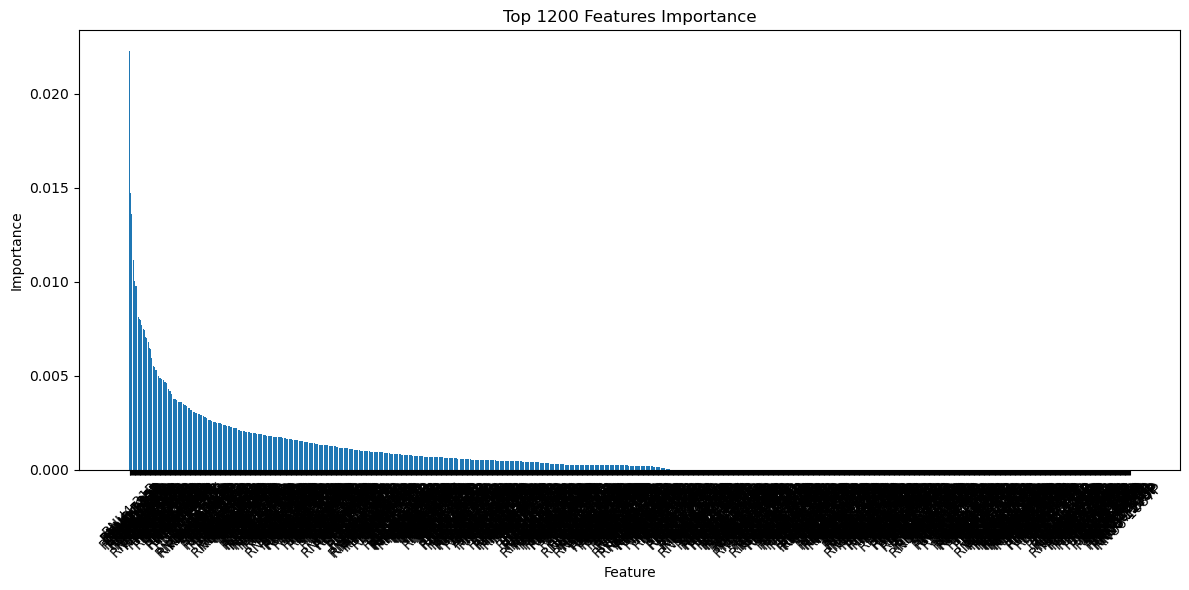

Last important feature:  650


In [11]:
df = pd.read_csv("../Datasets/Dataset10/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_names = X.columns

k_values = [1200]

selected_features_dict = {}

for k in k_values:
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    feature_importances = clf.feature_importances_
    selected_features = np.array(feature_names)[
        np.argsort(feature_importances)[::-1][:k]]

    selected_features_dict[k] = selected_features

    sorted_idx = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title(f"Top {k} Features Importance")
    plt.bar(range(k), feature_importances[sorted_idx][:k], align="center")
    plt.xticks(range(k), np.array(feature_names)[sorted_idx][:k], rotation=45)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

    zero_importance_index = np.where(feature_importances == 0)[0]
    print("Last important feature: ", len(
        X.columns)-len(zero_importance_index))

### Feature Selection

In [12]:
df = pd.read_csv("../Datasets/Dataset10/data2.csv", index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

feature_counts = list(range(1, 144))

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

feature_importances = clf.feature_importances_

selected_features = X.columns[np.argsort(feature_importances)[::-1]]

datasets = {}
for count in feature_counts:
    datasets[count] = X[selected_features[:count]].copy()
    datasets[count]['Diagnosis'] = y

for count, dataset in datasets.items():
    dataset.to_csv(
        f'../Datasets/Dataset10/Feature_Select/dataset_{count}.csv', index=True)

## Model Building

### Check CV Score for Different Models

In [13]:
feature_counts = list(range(1, 144))

models = {
    "SVM(linear)": SVC(kernel='linear'),
    "SVM(poly)": SVC(kernel='poly'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "ANN": MLPClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
}

results = pd.DataFrame(
    columns=["Model Name", "Feature Count", "CV Score (Mean +/- Std)"])

for count in tqdm(feature_counts, desc="Processing feature counts", unit=" feature counts", colour='green'):
    file_path = f"../Datasets/Dataset10/Feature_Select/dataset_{count}.csv"
    df = pd.read_csv(file_path, index_col=0)

    X = df.drop('Diagnosis', axis=1)
    y = df['Diagnosis']

    for model_name, model in models.items():
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
        if model_name == "ANN":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        elif model_name == "Logistic Regression": 
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=ConvergenceWarning)
                scores = cross_val_score(model, X, y, cv=cv)
        else:
            scores = cross_val_score(model, X, y, cv=cv)
        mean_score = np.mean(scores)
        std_score = np.std(scores)
        result = f"{mean_score:.4f} +/- {std_score:.4f}"
        new_data = pd.DataFrame({"Model Name": [model_name],
                                 "Feature Count": [count],
                                 "CV Score (Mean +/- Std)": [result]})
        results = pd.concat([results, new_data], ignore_index=True)
        # print(f"{model_name} with {count} features: {result}")

results.sort_values(by=["CV Score (Mean +/- Std)"],
                    ascending=False, inplace=True)
results.to_csv("../Datasets/Dataset10/Feature_Select/results.csv", index=False)

Processing feature counts: 100%|██████████| 143/143 [05:50<00:00,  2.45s/ feature counts]


In [14]:
df = pd.read_csv("../Datasets/Dataset10/Feature_Select/results.csv")
df.head(10)

,Model Name,Feature Count,CV Score (Mean +/- Std)
0,Random Forest,21,0.8207 +/- 0.0798
1,Random Forest,23,0.8138 +/- 0.0915
2,Random Forest,117,0.8138 +/- 0.0640
3,Random Forest,71,0.8138 +/- 0.0601
4,Random Forest,36,0.8138 +/- 0.0560
5,Random Forest,59,0.8138 +/- 0.0560
6,Random Forest,55,0.8138 +/- 0.0516
7,Random Forest,56,0.8138 +/- 0.0516
8,Random Forest,118,0.8138 +/- 0.0468
9,Random Forest,114,0.8138 +/- 0.0468


### Check Distributions

In [16]:
feature_count = 21

data = pd.read_csv(
    f'../Datasets/Dataset10/Feature_Select/dataset_{feature_count}.csv')

target_column = data.columns[feature_count + 1]

num_rows = math.ceil(feature_count / 4)
num_columns = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(80, 140))

for i in range(min(feature_count, num_rows * num_columns)):
    row_index = i // num_columns
    col_index = i % num_columns

    sns.histplot(
        data=data, x=data.columns[i + 1], hue=target_column, kde=True, ax=axes[row_index, col_index])

    axes[row_index, col_index].set_title(
        f'Distribution of {data.columns[i + 1]}')

    axes[row_index, col_index].set_xlabel(data.columns[i + 1])

    axes[row_index, col_index].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

### Check Accuracy

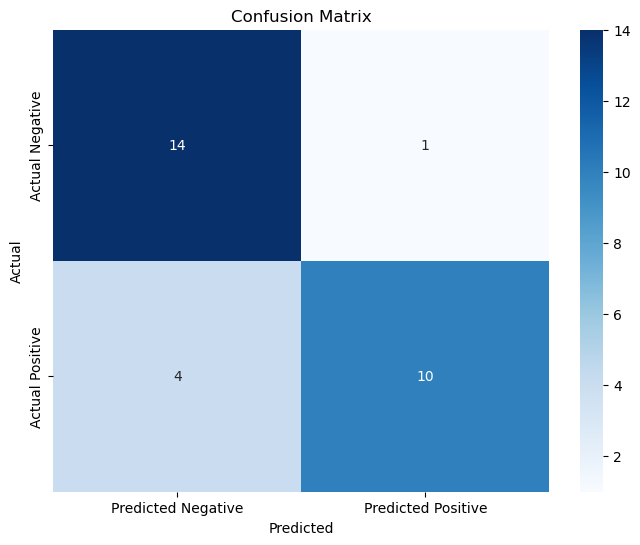

Accuracy: 0.83
Precision: 0.91
Recall (Sensitivity): 0.71
Specificity: 0.93
F1 Score: 0.80


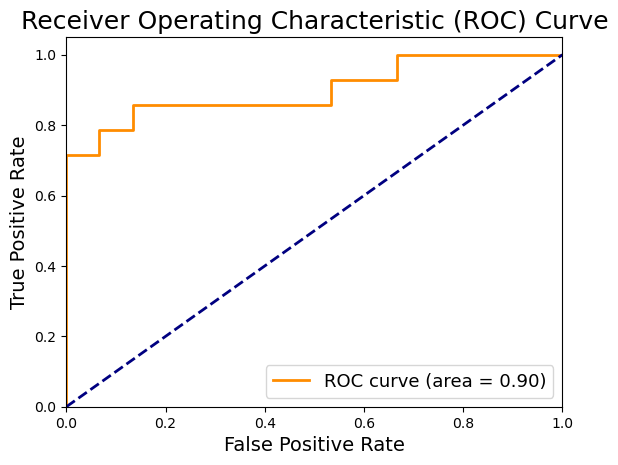

In [17]:
feature_count = 21

df = pd.read_csv(
    f'../Datasets/Dataset10/Feature_Select/dataset_{feature_count}.csv', index_col=0)

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

y_scores = clf.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
plt.legend(loc='lower right', fontsize=13)
plt.show()